### Przygotowanie danych

In [1]:
# Import bibliotek
import numpy as np

import random
import pandas as pd

from sklearn.model_selection import train_test_split
from livelossplot import PlotLossesKeras
from livelossplot.keras import PlotLossesCallback
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [31]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPool2D, Lambda
import keras
#!pip install livelossplot
from livelossplot import PlotLossesKeras
from livelossplot.keras import PlotLossesCallback
from PIL import Image
from os import listdir
from os.path import splitext


In [3]:
# Wczytanie tensorów X i y
X = np.load('X.npy')
y = np.load('y.npy')

print(X.shape, y.shape)

(6000, 128, 128, 3) (6000,)


In [4]:
# Podział danych X i y na zbiór treningowy i walidacyjny
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2019)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4800, 128, 128, 3) (4800,)
(1200, 128, 128, 3) (1200,)


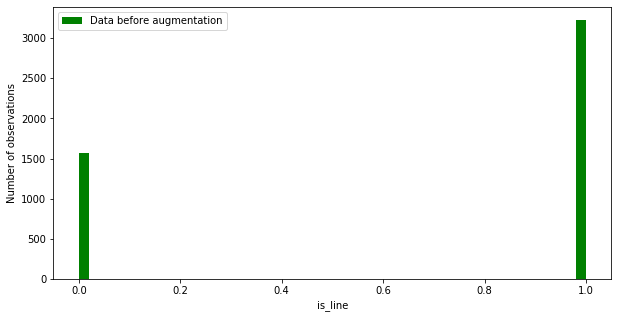

In [5]:
# Porównanie histogramów przed i po augmentacji
plt.figure(figsize=(10,5))
plt.hist(y_train, 50, facecolor='green');
#plt.hist(ygen, 50, facecolor='red');
plt.xlabel('is_line');
plt.ylabel('Number of observations');
plt.legend(['Data before augmentation']);
plt.show()

In [6]:
# Zmiana wymiarów macierzy X - reshape i nadpisanie wyników
#X_train = X_train.reshape(-1, img_rows, img_cols, 1 ) #-1: przepisuje dany nr zdjęcia, 28x28 są stałe, 
#można je przepisać, 1: dodany wymiar
#X_test = X_test.reshape(-1, img_rows, img_cols, 1 )

#input_shape = (img_rows, img_cols, 1)

print('X_train.shape:',X_train.shape, ' X_test.shape:',X_test.shape)

X_train.shape: (4800, 128, 128, 3)  X_test.shape: (1200, 128, 128, 3)


In [7]:
# Przygotowanie wektora odpowiedzi y (nr klasy do której należy obraz)

#Krok 1. Sprawdzenie wymiaru wektora y
print('y_train.shape:',y_train.shape, 'y_test.shape:',y_test.shape) # wymiar
print('y_train[5]',y_train[5]) # przykładowy wiersz

y_train.shape: (4800,) y_test.shape: (1200,)
y_train[5] 1


In [8]:
#Krok 2. Kategoryzacja danych
# realizacja pętli: jeżeli długość wektora y jest równa 1 to:  skategoryzuj wektory wg numeru klasy
if len(y_train.shape)== 1:
    num_classes = len(set(y_train))
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

In [9]:
# Krok 3. Sprawdzenie wymiaru wektora y po edycji
print('y_train.shape:',y_train.shape, 'y_test.shape:',y_test.shape)
print(y_train[5])

y_train.shape: (4800, 2) y_test.shape: (1200, 2)
[0. 1.]


In [10]:
# Rozmiar obrazów:
img_rows, img_cols = X_train.shape[1],X_train.shape[2]
input_shape = (img_rows, img_cols, 3)

print('img_rows:',img_rows, 'img_cols:',img_cols, 'input_shape:', input_shape)

img_rows: 128 img_cols: 128 input_shape: (128, 128, 3)


## Ananliza architektury CNN

# Wariant 1. błąd 12%

In [30]:
#6. Budowa architektury CNN
model = Sequential([
    
    #pierwsza warstwa konwolucyjna: 32 filtry o rozmiarach 3x3 piksele
    Conv2D(filters=32, kernel_size=(3,3),input_shape=input_shape), 
    MaxPool2D(pool_size=(2,2)),
    # do zmniejszenia ilości danych, przegląd każdego kwadratu o wym. 2x2 
    # i zatrzymanie wartości największej z danego kwadratu

    Conv2D(filters=64, kernel_size=(3,3)),
    MaxPool2D(pool_size=(2,2)),
    
    Conv2D(filters=128, kernel_size=(3,3)),
    MaxPool2D(pool_size=(2,2)),
    
    Flatten(), # spłaszcza macierz 2D po filtracjach do wektora
    
    Dense(512,activation='relu'),
    Dense(num_classes,activation='softmax')]) 


In [31]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)            

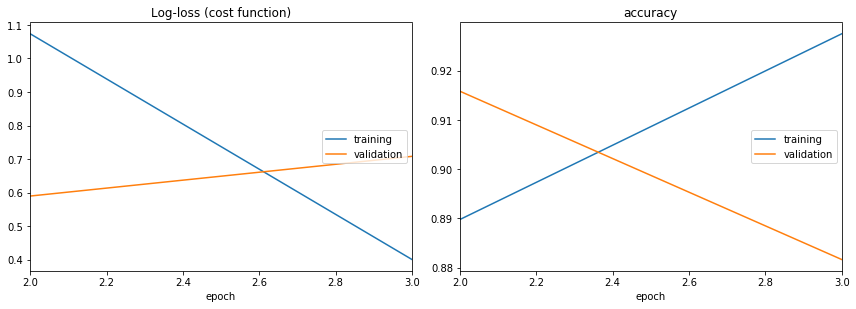

Log-loss (cost function):
training   (min:    0.401, max:    1.597, cur:    0.401)
validation (min:    0.590, max:    1.039, cur:    0.708)

accuracy:
training   (min:    0.870, max:    0.928, cur:    0.928)
validation (min:    0.882, max:    0.916, cur:    0.882)
[0.7081514866401751, 0.8816666603088379]


In [36]:
# Trenowanie modelu:
plot_losses = PlotLossesCallback()

history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=3,
          verbose=1,
          callbacks=[plot_losses],
          validation_data=(X_test, y_test))

score = model.evaluate(X_test, y_test, verbose=0)
print(score)

In [37]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print("CNN Error: %.2f%%" % (100-score[1]*100))

Test loss: 0.7081514866401751
Test accuracy: 0.8816666603088379
CNN Error: 11.83%


In [38]:
def draw_learning_curve(history, key='accuracy', ylim=(0.8, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(history.history[key])
    plt.plot(history.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'test'], loc='best')
    plt.show()

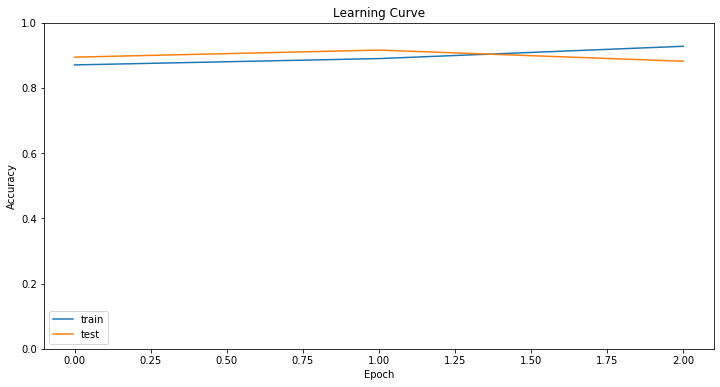

In [39]:
draw_learning_curve(history, key='accuracy', ylim=(0.0, 1.))

## Wariant 2. Błąd 10.5%

In [42]:
def get_simple_cnn():
    return Sequential([
        Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPool2D(pool_size=(2, 2)),
        
        Flatten(),
        
        Dense(512, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

get_simple_cnn().summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 63, 63, 16)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 63504)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               32514560  
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 1026      
Total params: 32,516,034
Trainable params: 32,516,034
Non-trainable params: 0
_________________________________________________________________


In [43]:
model = get_simple_cnn()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

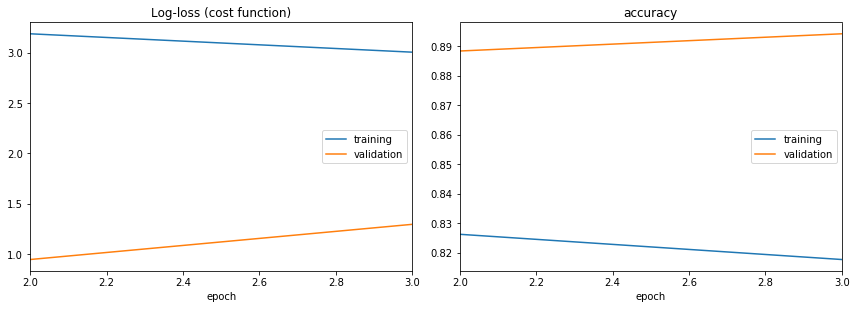

Log-loss (cost function):
training   (min:    3.005, max: 1017.680, cur:    3.005)
validation (min:    0.947, max:    6.057, cur:    1.296)

accuracy:
training   (min:    0.606, max:    0.826, cur:    0.818)
validation (min:    0.762, max:    0.894, cur:    0.894)


In [44]:
# Trening
plot_losses = PlotLossesCallback()

history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=3,
          verbose=1,
          callbacks=[plot_losses],
          validation_data=(X_test, y_test))


In [45]:
#Sprawdzenie:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print("CNN Error: %.2f%%" % (100-score[1]*100))

Test loss: 1.2959234424192496
Test accuracy: 0.8941666483879089
CNN Error: 10.58%


## Wariant 3. Błąd: 13%

In [46]:
def get_cnn2_nodroput():
    return Sequential([
        
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPool2D(pool_size=(2, 2)),
                
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
          
        Flatten(), #<= bridge between conv layers and full connected layers
        
        Dense(1024, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])


model = get_cnn2_nodroput()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              58983424  
_________________________________________________________________
dense_14 (Dense)             (None, 2)                

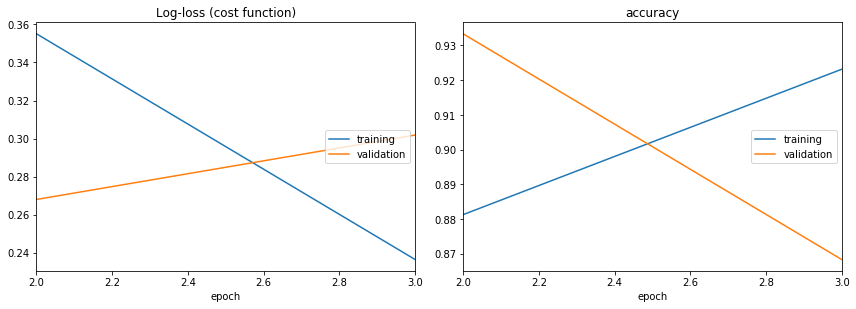

Log-loss (cost function):
training   (min:    0.236, max:  325.624, cur:    0.236)
validation (min:    0.268, max:    0.536, cur:    0.302)

accuracy:
training   (min:    0.779, max:    0.923, cur:    0.923)
validation (min:    0.862, max:    0.933, cur:    0.868)


In [47]:
# Trenowanie
plot_losses = PlotLossesCallback()

history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=3,
          verbose=1,
          callbacks=[plot_losses],
          validation_data=(X_test, y_test))

In [48]:
# Testowanie
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print("CNN Error: %.2f%%" % (100-score[1]*100))

Test loss: 0.3018563687801361
Test accuracy: 0.8683333396911621
CNN Error: 13.17%


## Wariant 4. Błąd: 2%

In [11]:
def get_doubled_cnn3_nodropout():
    return Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        
        Flatten(),
        
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])


model = get_doubled_cnn3_nodropout()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 128)      

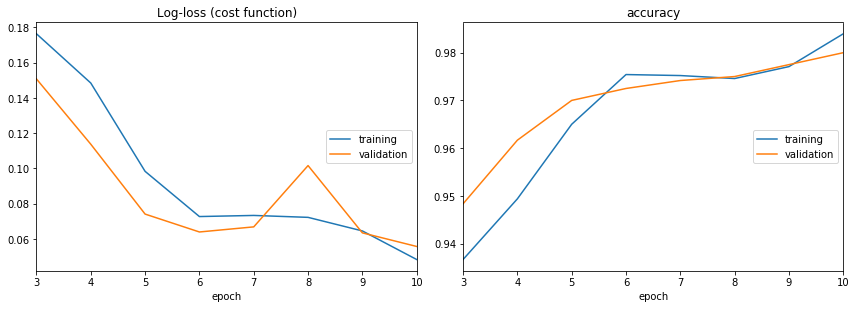

Log-loss (cost function):
training   (min:    0.048, max:    3.244, cur:    0.048)
validation (min:    0.056, max:    0.237, cur:    0.056)

accuracy:
training   (min:    0.798, max:    0.984, cur:    0.984)
validation (min:    0.912, max:    0.980, cur:    0.980)


In [12]:
# Training
plot_losses = PlotLossesCallback()

history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          callbacks=[plot_losses],
          validation_data=(X_test, y_test))

In [13]:
# Testing
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print("CNN Error: %.2f%%" % (100-score[1]*100))

Test loss: 0.055670015790189306
Test accuracy: 0.9800000190734863
CNN Error: 2.00%


In [67]:
# Sprawdzenie zbioru randomowych zdjęć
random_test = 'D:/SF/LINIE/PLD_IR_VIS/random_test/'
base = '.bmp'
filename_tested_list = []
prediction_list = []
is_line_list=[]

for file in listdir(random_test):
    filename, extension = splitext(file)
    img = np.asarray(Image.open(random_test + file))
    
    img_rows, img_cols = img.shape[0],img.shape[1] #reshape
    img =img.reshape(-1, img_rows, img_cols, 3 )
    
    #predykcja
    predykcja = model.predict(img)
    is_line=predykcja.argmax()
    prediction_list.append(predykcja)
    is_line_list.append(is_line)
    
    filename_tested_list.append(random_test + file)

df_tested = pd.DataFrame.from_dict({'path':filename_tested_list})
df_predicted = pd.DataFrame.from_dict({'path':filename_tested_list,'prediction':is_line_list})

is_line_list

[0, 0, 1, 0, 1, 0, 1, 0, 0, 1]

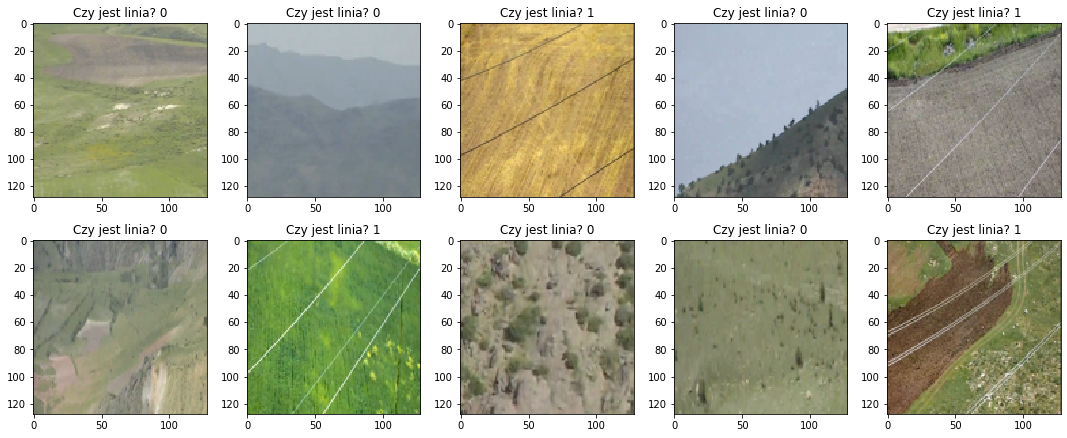

In [68]:
# wizualizacja testowych zdjęć

plt.figure(figsize=(15,15))

nr_img = np.random.randint(10, size=(1, 10))

for idx in range(10): # tu trzeba zrobić żeby nie wpisywać z alca liczby zdjęć w folderze
    plt.subplot(5,5,idx+1)
    img = Image.open(df_tested['path'][idx])
    
    plt.imshow(img)
    plt.title('Czy jest linia? {}'.format(df_predicted['prediction'][idx]))# wyjściowa klasa 
    
plt.tight_layout()